In [1]:
from rl_ood import *
path = Path.cwd()

# OOD environments instantiation

In [2]:
default_values = MOUNTAIN_CAR_VALUES
default_values

{'Gravity': 0.0025, 'Force': 0.001}

Each ood config differs from the defaut environment by only one attribute.

In [3]:
values = create_ood_values(default_values)
ood_configs = get_ood_configs(values, values)
len(ood_configs)




20

In [4]:
ood_configs[0]

{'Gravity': 7.8125e-05, 'Force': 0.001, 'change': 'Gravity'}

# Evaluate OOD impact

### Original environment

We train an agent on the original environment, and we evaluate its performances

In [5]:
instanciate_mountain_car(default_values)


<TimeLimit<MountainCarEnv<MountainCar-v0>>>

In [6]:
env = instanciate_mountain_car(default_values)
path_agent = path / 'Agents' / 'trained_mountain_car_10000'
#if os.path.exists(path_agent):
#    agent = DQN.load(path_agent)
#else:
agent = DQN('MlpPolicy', env, learning_rate=0.001, buffer_size=10000, learning_starts=50000, batch_size=128, tau=1.0, gamma=0.99, train_freq=4)
agent.learn(1000000, progress_bar=True)
agent.save(path_agent)
evaluate(env, agent, nb_episodes=10, render=True)

Output()

(-152.8, 19.229144546755066)

We evaluate this agent on several ood environments. We get the mean and std of the reward over 10 episodes.

In [7]:
ood_env = instanciate_mountain_car(ood_configs[0])
#agent = DQN.load(path/'Agents'/'mountain_car-v1.zip', env=ood_env)
agent = DQN.load(path/'Agents'/'trained_mountain_car_10000', env=ood_env)
evaluate(ood_env, agent, render=False)

(-1000.0, 0.0)

In [8]:
ood_env = instanciate_mountain_car(ood_configs[-1])
evaluate(ood_env, agent, render=False)

(-1000.0, 0.0)

### Impact of the ood on the reward

In [9]:
default_values, values = get_mountain_car_values()
results = {}
std_results = {}

original_env = instanciate_mountain_car(default_values)
agent = DQN.load(path/'Agents'/'trained_mountain_car_10000', env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciate_mountain_car(config)
    agent = DQN.load(path/'Agents'/'trained_mountain_car_10000', env=ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=100)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)
    #print(config, mean_reward)
    



100%|██████████| 20/20 [04:43<00:00, 14.16s/it]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

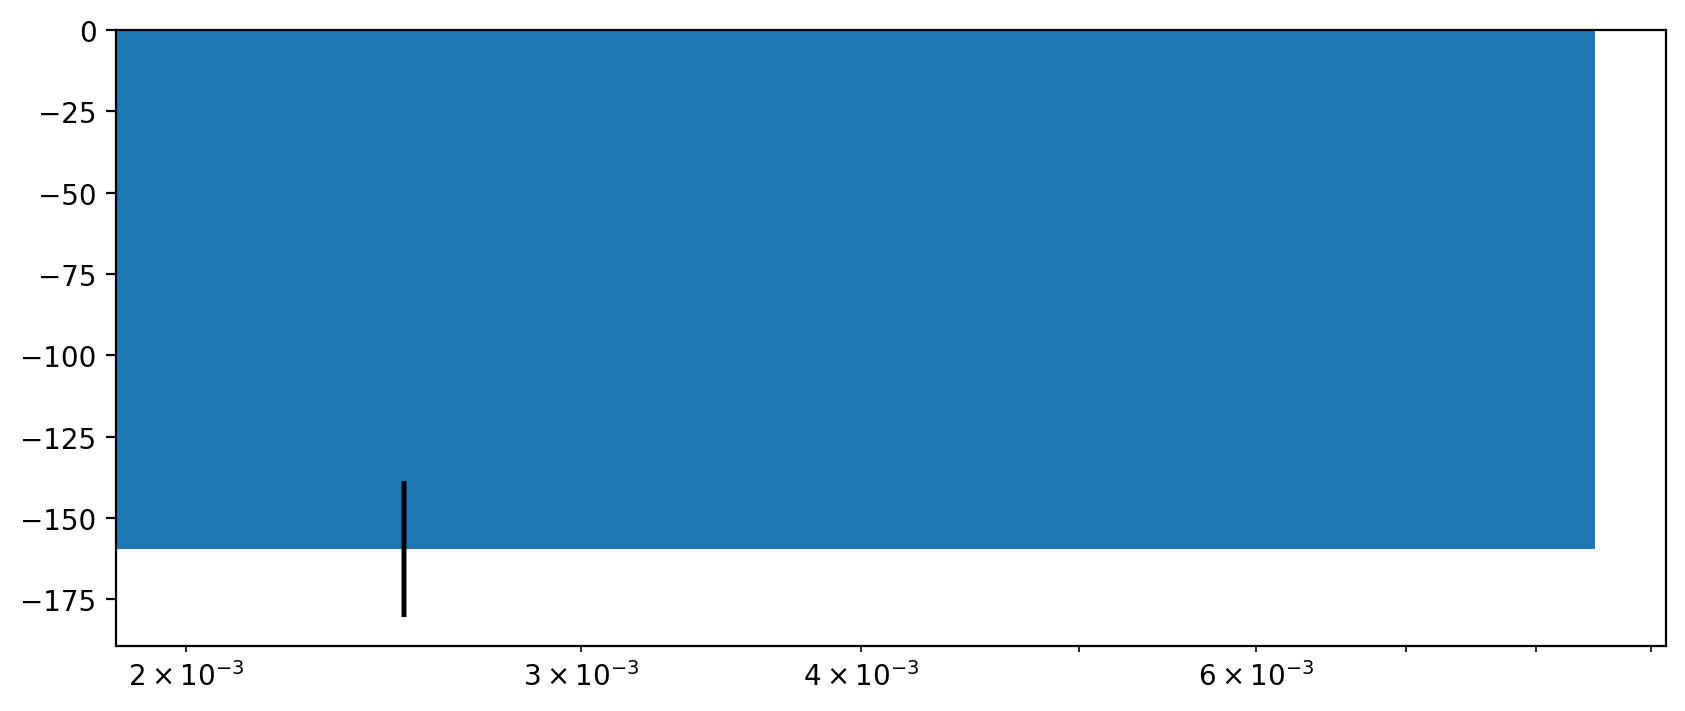

In [10]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 5
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)
    ax.bar(default_values[key], original_result, yerr=original_std_result, width=width, label='Original')

    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """
    

# Create OOD detector

The configuration ood detector is relative to its default environment

In [ ]:
default_values, values = get_mountain_car_values()
env = instanciate_mountain_car(default_values)
ood_detector = MartingaleOODDetector(env, verbose=False)
default_values

{'Gravity': 0.0025, 'Force': 0.001}

We have a low ood score on the delaut environment

In [ ]:
ood_detector.get_in_distrib_score()

0.4972160309033415

It should be higher on ood environment

In [ ]:
ood_config = get_ood_configs(default_values, values)[-1]
ood_env = instanciate_mountain_car(ood_config)
ood_config

{'Gravity': 0.0025, 'Force': 0.1, 'change': 'Force'}

In [ ]:
ood_score = ood_detector.test_ood(ood_env, nb_steps=100)
ood_score

0.5173415810773825

Let's compute the ood scores of the previously studies ood environments

In [ ]:
default_values, values = get_mountain_car_values()
mean_ood_scores = {}
std_ood_scores = {}

original_env = instanciate_mountain_car(default_values)
agent = DQN.load(path/'Agents'/'trained_mountain_car_10000', env=original_env)
ood_detector = MartingaleOODDetector(env)
in_distrib_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_scores:
        mean_ood_scores[config['change']] = []
        std_ood_scores[config['change']] = []
    
    ood_env = instanciate_mountain_car(config)
    agent = DQN.load(path/'Agents'/'trained_mountain_car_10000', env=ood_env)
    list_scores = np.array([ood_detector.test_ood(ood_env, nb_steps=100) for _ in range(10)])
    ood_score = list_scores.mean()
    std_score = list_scores.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_scores[config['change']].append(ood_score)
    std_ood_scores[config['change']].append(std_score)
    #print(config, mean_reward)
    



100%|██████████| 13/13 [00:02<00:00,  4.71it/s]


We now realise a plot of the mean reward and ood scores of each environment. The ones of the delaut environment are in darker colour at the middle of the plot.

100%|██████████| 2/2 [00:00<00:00, 31.56it/s]


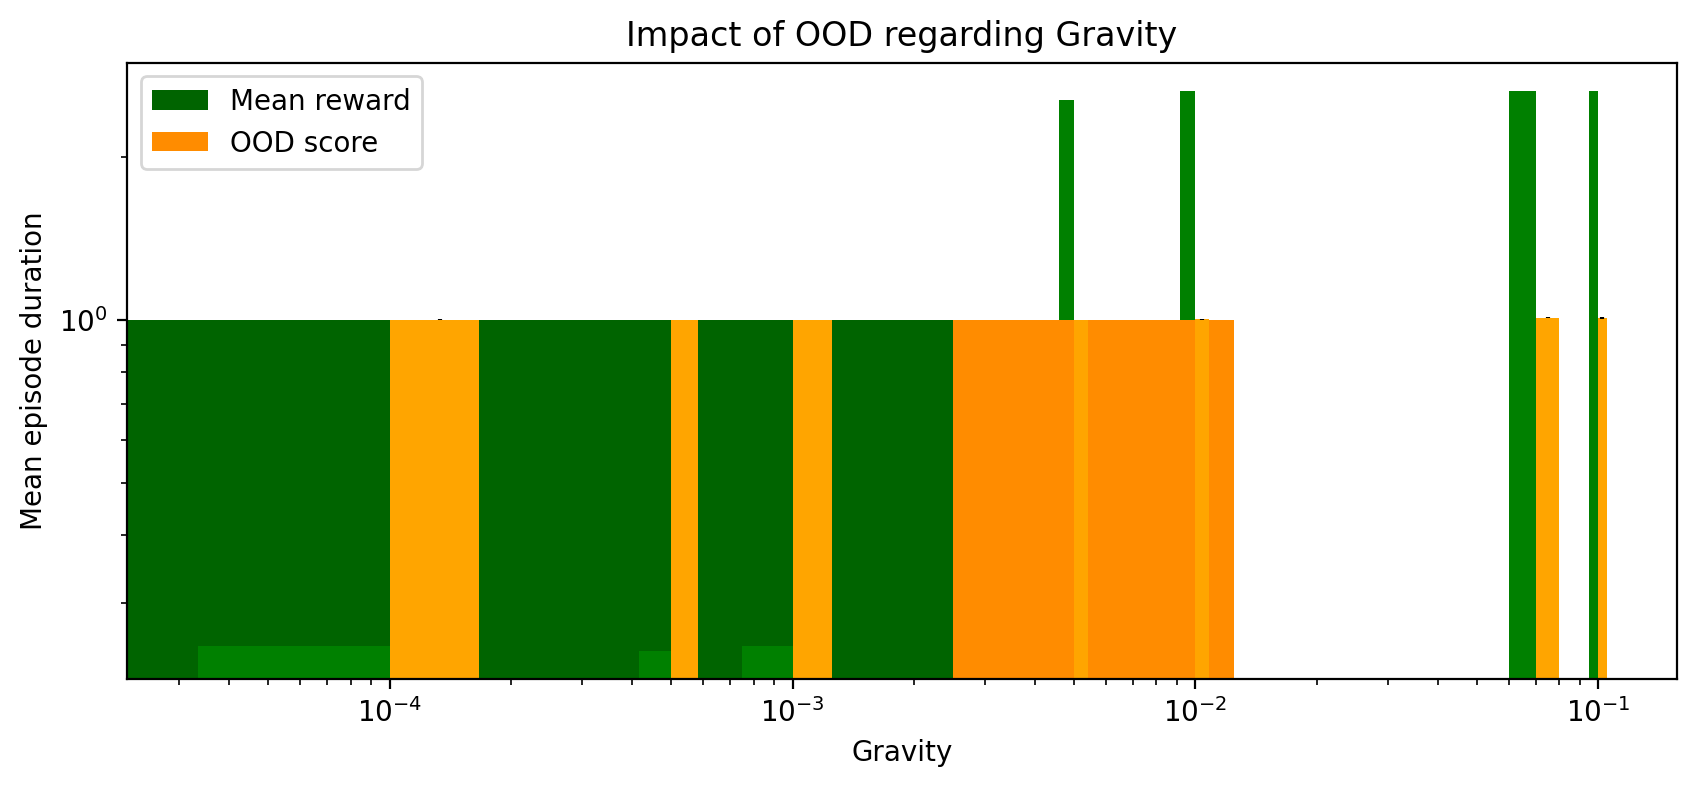

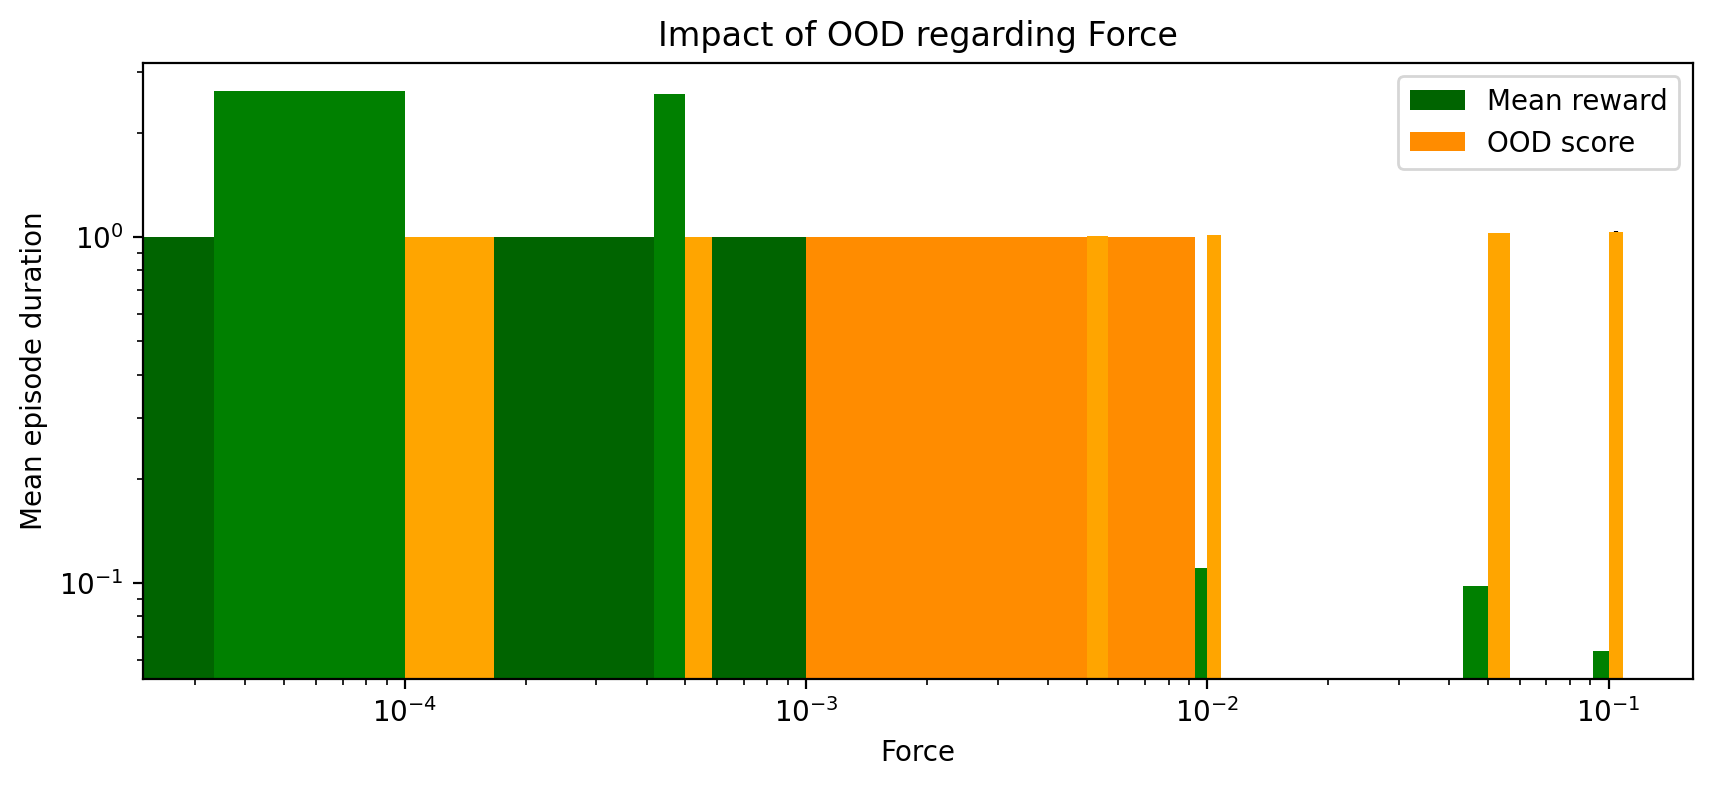

In [ ]:
from turtle import color


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 6

    ax.bar(default_values[key]- width/2, 1.0, width=width, label='Mean reward', color='darkgreen')
    ax.bar(values[key]- width/2, results[key]/original_result, width=width,  color='green')

    ax.bar(default_values[key]+width/2, 1.0, width=width, label='OOD score', color='darkorange')
    ax.bar(values[key]+ width/2, mean_ood_scores[key]/in_distrib_score, width=width, color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

We add as maning in distribution examples and there are ood examples

In [ ]:
original_env = instanciate_mountain_car(default_values)
agent = DQN.load(path/'Agents'/'trained_mountain_car_10000', env=original_env)

list_scores = []
for _ in trange(5*18):
    list_scores.append(np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(10)]).mean())

mean_ood_scores['None'] = list_scores

100%|██████████| 90/90 [00:21<00:00,  4.25it/s]


# Computation of the AUC score

In [ ]:
def compute_AUC(mean_ood_scores, plot=True, verbose=False):
    TPRs = []
    FPRs = []

    thresholds = [10**(-i/10) for i in range(-50, 50+1)]
    for threshold in thresholds:
        false_pos=0
        false_neg=0
        true_pos=0
        true_neg=0

        for key in mean_ood_scores:
            if str(key) != 'None': # Env OOD
                for test_res in mean_ood_scores[key]:

                    if test_res<threshold: # Not detected as OOD
                        false_neg +=1
                    else:
                        true_pos +=1
            else: # Env standard
                for test_res in mean_ood_scores[key]:

                    if test_res>threshold: # Detected as OOD
                        false_pos +=1
                    else:
                        true_neg +=1


        try:
            tpr = true_pos/(true_pos+false_neg)
        except ZeroDivisionError:
            print('error computing tpr')
            continue
            tpr = 1.0
        
        try:
            fpr = false_pos/(false_pos+true_neg)
        except ZeroDivisionError:
            print('error computing fpr')
            continue

        if verbose:
            print(threshold)
            print('TP', true_pos, 'FP',false_pos)
            print('FN', false_neg, 'TN',true_neg)
            print()
            print(tpr, fpr)
        TPRs.append(tpr)
        FPRs.append(fpr)
        #AUC += tpr/len(thresholds)

    if verbose:
        plt.title("TPR and FPR curves")
        plt.plot(TPRs, label='TPR')
        plt.plot(FPRs, label='FPR')
        plt.legend()
        plt.show()
        
    #print('AUC: ', AUC)
    plt.title("ROC curve")
    plt.plot(FPRs, TPRs,'-*')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.show()

    AUC = integrate.simps(x=FPRs, y=TPRs, even='avg')
    return AUC

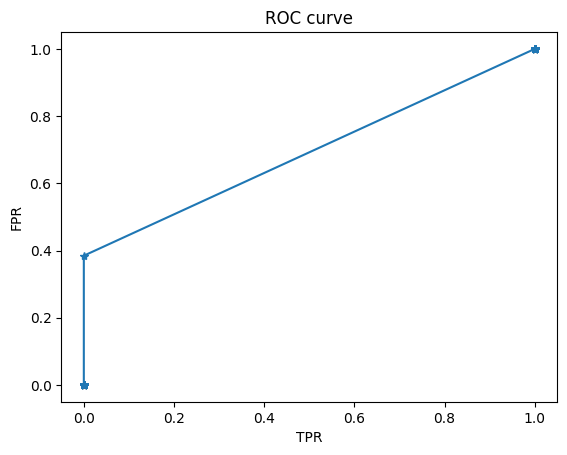

0.3333333333333333

In [ ]:
compute_AUC(mean_ood_scores)